**Data Preparation:**

Use the provided dataset containing normal and TB X-ray images.
Split the dataset into training, validation, and test sets.


In [ ]:
import os
import zipfile
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# 1. Unzip dataset
zip_path = '/content/archive.zip'
extract_path = '/content/chest_xray'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Base folder where dataset is extracted
base_path = '/content/chest_xray/Dataset of Tuberculosis Chest X-rays Images'

normal_dir = os.path.join(base_path, 'Normal Chest X-rays')
tb_dir = os.path.join(base_path, 'TB Chest X-rays')

# New directories to hold split datasets
split_base = '/content/chest_xray_split'
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(split_base, split, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(split_base, split, 'TB'), exist_ok=True)

# Function to split and copy images
def split_and_copy_images(class_dir, class_name):
    all_images = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]

    train_imgs, temp_imgs = train_test_split(all_images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(split_base, 'train', class_name, img))

    for img in val_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(split_base, 'val', class_name, img))

    for img in test_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(split_base, 'test', class_name, img))

# Apply split for both classes
split_and_copy_images(normal_dir, 'NORMAL')
split_and_copy_images(tb_dir, 'TB')


**Data Cleaning and Preprocessing:**

Resize images, normalize pixel values, and apply augmentations.
Ensure class balance and handle missing/corrupt images.
[link text](https://)

Found 2104 images belonging to 2 classes.
Found 451 images belonging to 2 classes.
Found 453 images belonging to 2 classes.


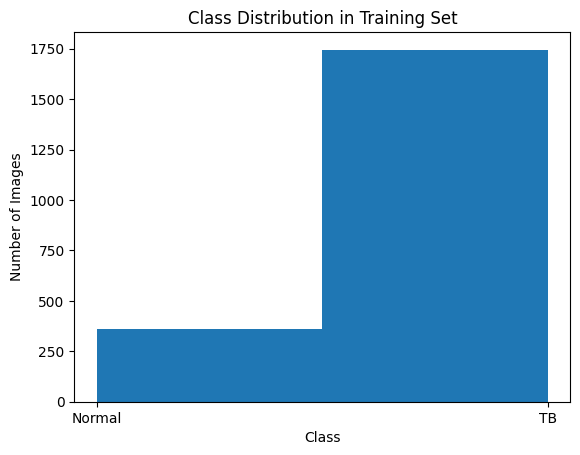

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np


# Set image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Augment only training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation & test data should not be augmented
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Directory paths
train_dir = '/content/chest_xray_split/train'
val_dir = '/content/chest_xray_split/val'
test_dir = '/content/chest_xray_split/test'

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # since it's a binary classification problem
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Don't shuffle for evaluation
)

#Data augmentation for minority class only (we can modify the pipeline).
labels = train_generator.classes
plt.hist(labels, bins=2)
plt.xticks([0, 1], ['Normal', 'TB'])
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()



In [ ]:
#for corrupted images
import os
from PIL import Image

def find_corrupt_images(directory):
    corrupt_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()  # Verifies image integrity
            except Exception as e:
                corrupt_files.append(img_path)
    return corrupt_files

# Example usage
corrupt = find_corrupt_images(train_dir)
print("Corrupt images:", corrupt)


Corrupt images: []


Keras’s flow_from_directory will skip unreadable images and raise warnings for missing files.

**Exploratory Data Analysis (EDA):**

Visualize image distribution, pixel intensity statistics, and class balance for normal data


Normal images: 514
TB images: 2494


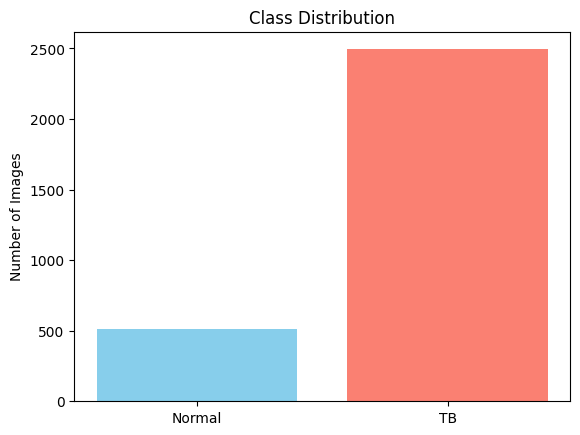

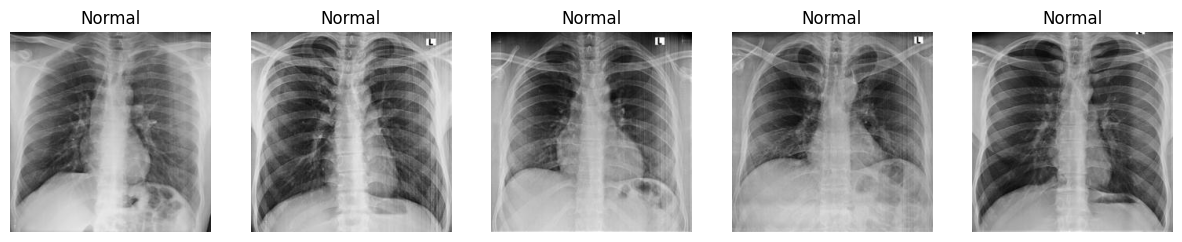

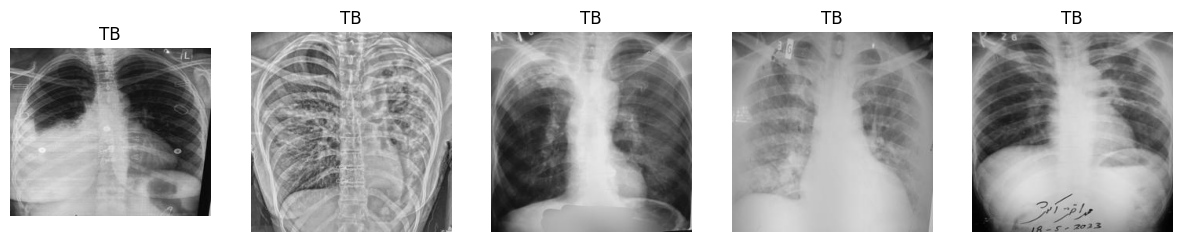

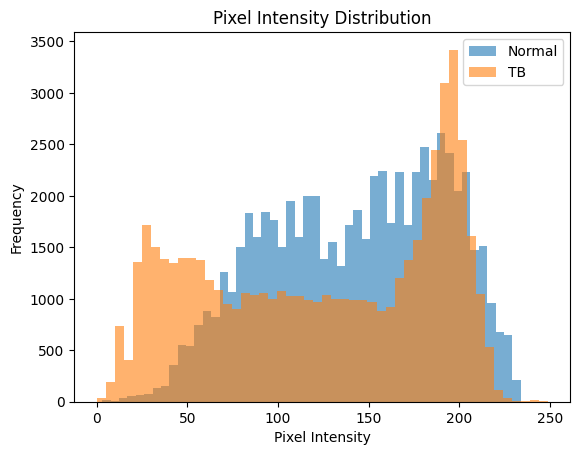

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
base_dir = '/content/chest_xray/Dataset of Tuberculosis Chest X-rays Images'
normal_dir = os.path.join(base_dir, 'Normal Chest X-rays')
tb_dir = os.path.join(base_dir, 'TB Chest X-rays')

#Count and Plot Class Balance
normal_images = os.listdir(normal_dir)
tb_images = os.listdir(tb_dir)

print(f"Normal images: {len(normal_images)}")
print(f"TB images: {len(tb_images)}")

plt.bar(['Normal', 'TB'], [len(normal_images), len(tb_images)], color=['skyblue', 'salmon'])
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()

#Show Sample Images from Each Class
def show_samples(image_list, title, img_dir, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img_path = os.path.join(img_dir, image_list[i])
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"{title}")
    plt.show()

show_samples(normal_images, 'Normal', normal_dir)
show_samples(tb_images, 'TB', tb_dir)

#Plot Pixel Intensity Distribution
def plot_pixel_distribution(img_path, label):
    img = Image.open(img_path).convert('L')  # Grayscale
    img_arr = np.array(img).flatten()

    plt.hist(img_arr, bins=50, alpha=0.6, label=label)

# Choose random images
plot_pixel_distribution(os.path.join(normal_dir, normal_images[0]), 'Normal')
plot_pixel_distribution(os.path.join(tb_dir, tb_images[0]), 'TB')

plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()



**Exploratory Data Analysis (EDA):**

Visualize image distribution, pixel intensity statistics, and class balance.




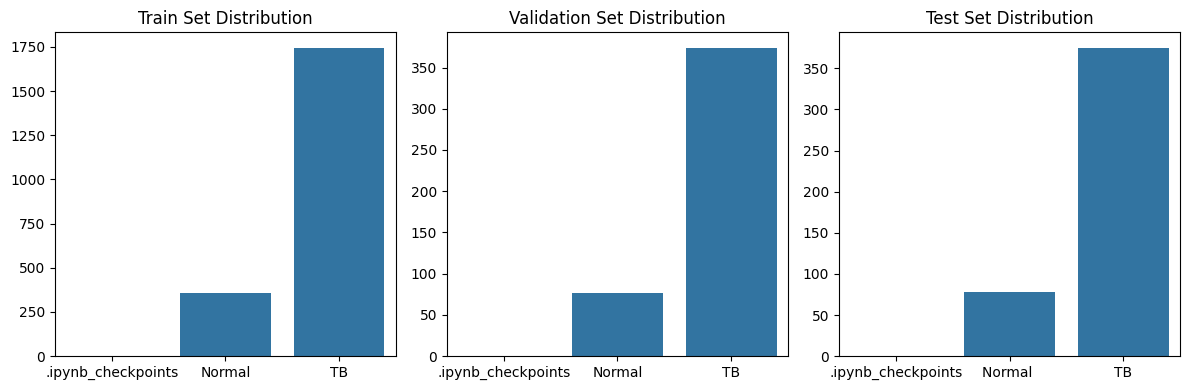

Sample Normal X-rays:


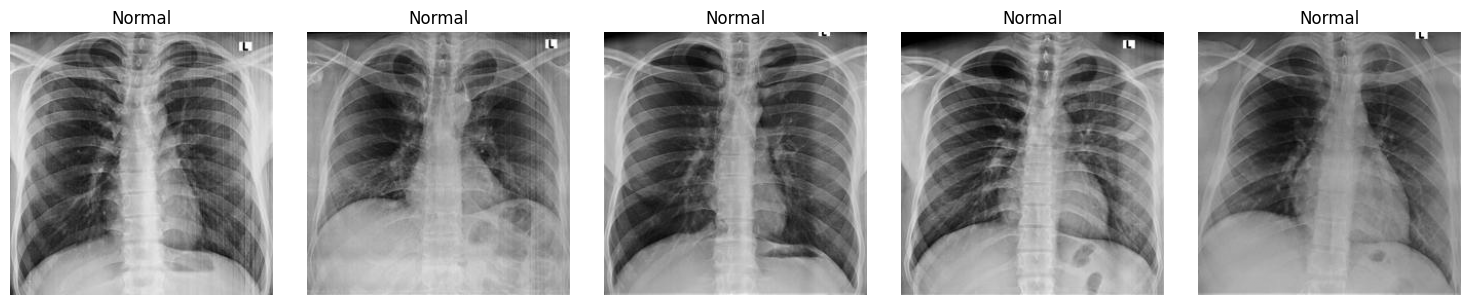

Sample TB X-rays:


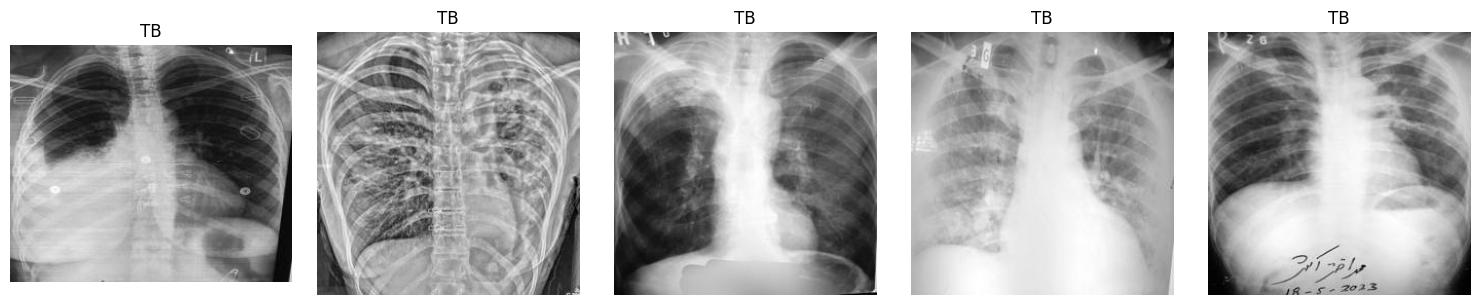

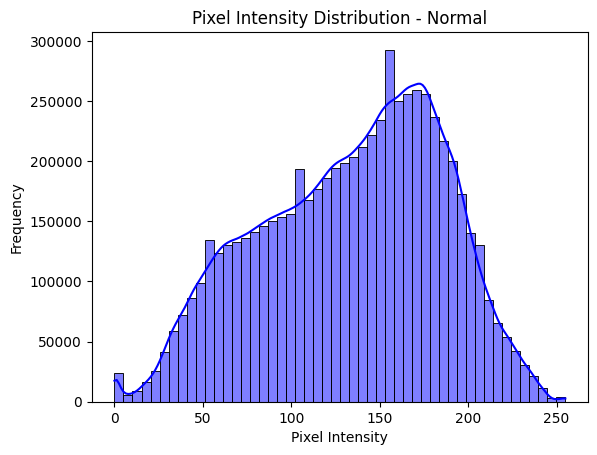

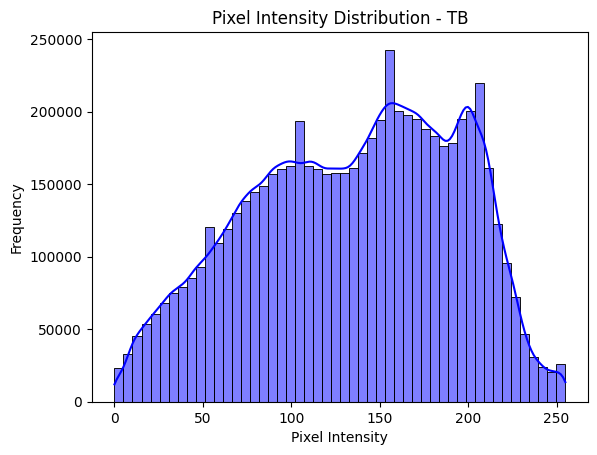

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
from PIL import Image

# Define paths
base_dir = '/content/chest_xray_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Helper function to count images in each class
def count_images(directory):
    labels = os.listdir(directory)
    count_dict = {}
    for label in labels:
        label_path = os.path.join(directory, label)
        count_dict[label] = len(os.listdir(label_path))
    return count_dict

# 1. Class Distribution in Train, Val, Test
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Plot class distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Train Set Distribution')
plt.subplot(1, 3, 2)
sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()))
plt.title('Validation Set Distribution')
plt.subplot(1, 3, 3)
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
plt.title('Test Set Distribution')
plt.tight_layout()
plt.show()

# 2. Show Sample Images
def show_samples(class_dir, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, img_name in enumerate(os.listdir(class_dir)[:5]):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path).convert('L')  # grayscale
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(title)
    plt.tight_layout()
    plt.show()

print("Sample Normal X-rays:")
show_samples(os.path.join(train_dir, 'Normal'), 'Normal')

print("Sample TB X-rays:")
show_samples(os.path.join(train_dir, 'TB'), 'TB')

# 3. Pixel Intensity Distribution
def plot_pixel_distribution(class_dir, label):
    all_pixels = []
    for img_name in os.listdir(class_dir)[:100]:  # take 100 images to limit processing
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            all_pixels.extend(img.flatten())
    sns.histplot(all_pixels, bins=50, kde=True, color='blue')
    plt.title(f'Pixel Intensity Distribution - {label}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_pixel_distribution(os.path.join(train_dir, 'Normal'), 'Normal')
plot_pixel_distribution(os.path.join(train_dir, 'TB'), 'TB')


In [ ]:
#Train Models
# 1. ResNet50
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in resnet_base.layers:
    layer.trainable = False
resnet_model = build_model(resnet_base)
resnet_history = train_model(resnet_model)

# 2. VGG16
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in vgg_base.layers:
    layer.trainable = False
vgg_model = build_model(vgg_base)
vgg_history = train_model(vgg_model)

# 3. EfficientNetB0
eff_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in eff_base.layers:
    layer.trainable = False
eff_model = build_model(eff_base)
eff_history = train_model(eff_model)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 51s 561ms/step - accuracy: 0.1083 - loss: -0.5233 - val_accuracy: 0.1707 - val_loss: -6.7182
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 395ms/step - accuracy: 0.1601 - loss: -8.3296 - val_accuracy: 0.1707 - val_loss: -15.2274
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 395ms/step - accuracy: 0.1628 - loss: -17.8878 - val_accuracy: 0.1707 - val_loss: -26.2196
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 393ms/step - accuracy: 0.1652 - loss: -29.1109 - val_accuracy: 0.1707 - val_loss: -38.6219
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 397ms/step - accuracy: 0.1687 - loss: -42.4571 - val_accuracy: 0.1707 - val_loss: -52.7698
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 402ms/step - accuracy: 0.1679 - loss: -57.8570 - val_accuracy: 0.1707 - val_loss: -68.5917
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 398ms/step - accuracy: 0.1675 - loss: -72.9268 - val_accuracy: 0.1707 - val_loss: -86.0939
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 397ms/step - accuracy: 0.1666 

**Model Development:**

Train multiple deep learning models using Transfer Learning (ResNet50, VGG16, EfficientNetB0).
Experiment with hyperparameter tuning, dropout, and data augmentation.



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os

#Image Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/chest_xray_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    '/content/chest_xray_split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/chest_xray_split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Model Builder Function
def build_model(base_model, dropout_rate=0.5):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

#Training Function
def train_model(model, epochs=10, lr=0.0001):
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs
    )
    return history

Found 2104 images belonging to 3 classes.
Found 451 images belonging to 3 classes.
Found 453 images belonging to 3 classes.


**Model Evaluation and Comparison:**

Use metrics like accuracy, precision, recall, F1-score, and ROC-AUC.


Found 453 images belonging to 3 classes.
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step

📋 Classification Report for VGG16:

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        78
Tuberculosis       0.83      1.00      0.91       375

    accuracy                           0.83       453
   macro avg       0.41      0.50      0.45       453
weighted avg       0.69      0.83      0.75       453



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


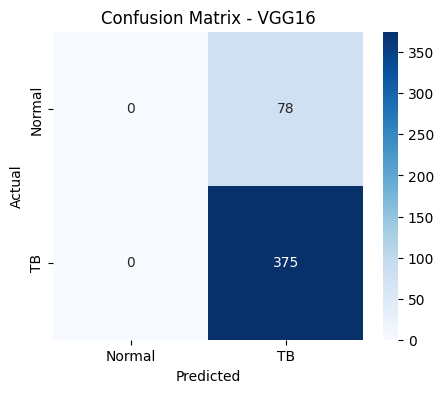

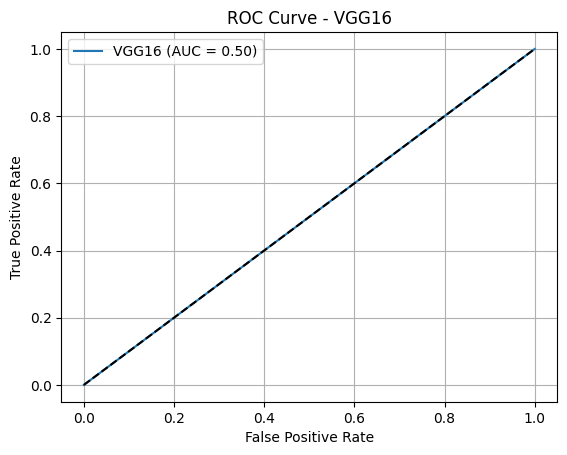

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 421ms/step

📋 Classification Report for ResNet50:

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        78
Tuberculosis       0.83      1.00      0.91       375

    accuracy                           0.83       453
   macro avg       0.41      0.50      0.45       453
weighted avg       0.69      0.83      0.75       453



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


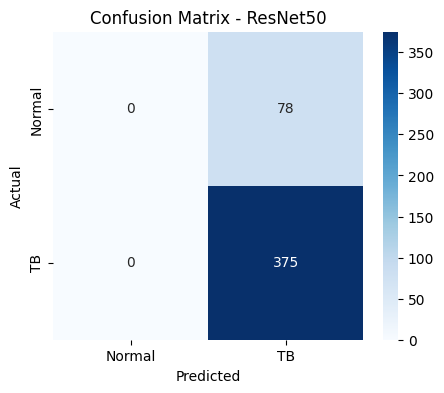

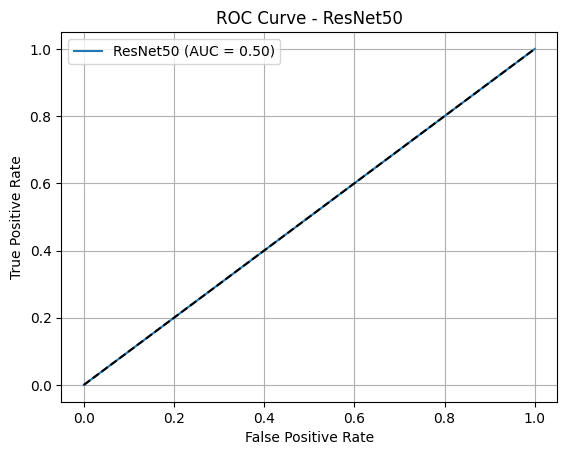

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 604ms/step

📋 Classification Report for EfficientNetB0:

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        78
Tuberculosis       0.83      1.00      0.91       375

    accuracy                           0.83       453
   macro avg       0.41      0.50      0.45       453
weighted avg       0.69      0.83      0.75       453



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


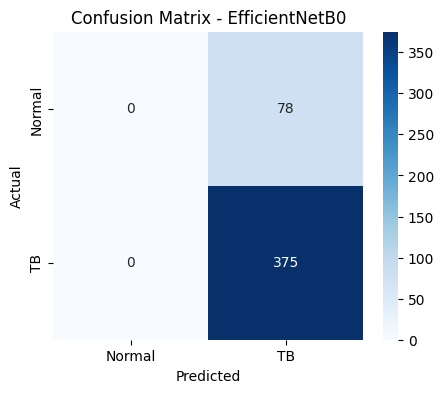

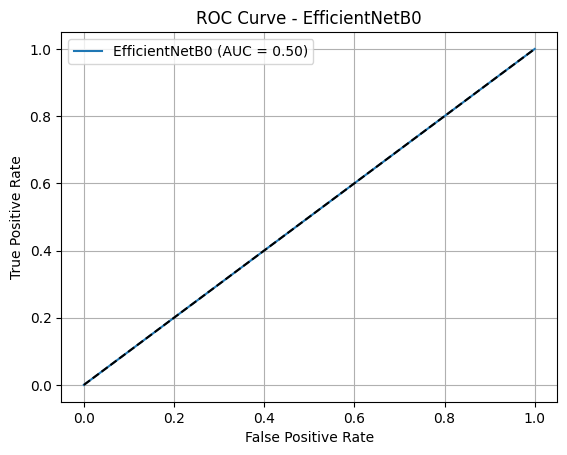


📊 Model Performance Comparison:


,Accuracy,Precision,Recall,F1 Score,ROC AUC
VGG16,0.827815,0.827815,1.000000,0.905797,0.500000
ResNet50,0.827815,0.827815,1.000000,0.905797,0.500000
EfficientNetB0,0.827815,0.827815,1.000000,0.905797,0.500000


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/chest_xray_split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Dictionary to store metrics for comparison
model_metrics = {}

def evaluate_model(name, model, generator):
    y_true = generator.classes - 1  # Convert labels to {0, 1}
    y_pred_probs = model.predict(generator)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred_probs)

    model_metrics[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': auc_score
    }

    # Classification Report
    print(f"\n📋 Classification Report for {name}:\n")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Tuberculosis']))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'TB'], yticklabels=['Normal', 'TB'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage (use your own trained models here)
evaluate_model("VGG16", vgg_model, test_generator)
evaluate_model("ResNet50", resnet_model, test_generator)
evaluate_model("EfficientNetB0", eff_model, test_generator)

# After evaluating all models
def show_model_comparison():
    df = pd.DataFrame(model_metrics).T
    print("\n📊 Model Performance Comparison:")
    display(df.style.background_gradient(cmap='YlGnBu'))

# Call this after evaluating all models
show_model_comparison()


In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.4 MB/s eta 0:00:00


In [ ]:
vgg_model.save('vgg_model.h5')
from google.colab import files
files.download('vgg_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
resnet_model.save('resnet_model.h5')
from google.colab import files
files.download('resnet_model.h5')

eff_model.save('eff_model.h5')
from google.colab import files
files.download('eff_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Application Development:**

Build a Streamlit-based interface for users to upload X-ray images and receive predictions.


In [ ]:
import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import io

# Load model
@st.cache_resource
def load_trained_model():
    model = load_model("vgg_model.h5")  # Update path if needed
    return model

model = load_trained_model()

# App title
st.title("🩻 Chest X-ray TB Classifier")
st.write("Upload a chest X-ray image to check if it shows signs of **Tuberculosis**.")

# Upload image
uploaded_file = st.file_uploader("Upload X-ray Image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display image
    img = Image.open(uploaded_file)
    st.image(img, caption='Uploaded X-ray', use_column_width=True)

    # Preprocess image
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)[0][0]
    result = "Tuberculosis" if prediction > 0.5 else "Normal"

    st.subheader("Prediction:")
    st.write(f"🧠 **{result}** (Confidence: {prediction:.2f})")

    # Optional: add probability gauge or metrics


2025-05-05 12:33:18.869 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:33:18.985 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-05 12:33:18.987 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:33:18.989 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:33:19.163 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:33:19.163 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:33:19.165 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:33:19.167 Thread 'MainThread': mi

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.2, rotation_range=20, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/chest_xray_split/train', target_size=(224, 224), batch_size=32, class_mode='binary')

val_generator = val_test_datagen.flow_from_directory(
    '/content/chest_xray_split/val', target_size=(224, 224), batch_size=32, class_mode='binary')

# Model builder
def build_model(base_model, dropout_rate=0.5):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=predictions)

# Load VGG16 and build model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_base.layers:
    layer.trainable = False

vgg_model = build_model(vgg_base)

# Compile and train
vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
vgg_model.fit(train_generator, validation_data=val_generator, epochs=10)

# Save the trained model
vgg_model.save('vgg_model.h5')


Found 2104 images belonging to 2 classes.
Found 451 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 60s 699ms/step - accuracy: 0.5539 - loss: 0.8226 - val_accuracy: 0.8293 - val_loss: 0.4105
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 462ms/step - accuracy: 0.7952 - loss: 0.5291 - val_accuracy: 0.8293 - val_loss: 0.3881
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 473ms/step - accuracy: 0.8042 - loss: 0.4758 - val_accuracy: 0.8293 - val_loss: 0.3634
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 491ms/step - accuracy: 0.8111 - loss: 0.4566 - val_accuracy: 0.8293 - val_loss: 0.3405
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 470ms/step - accuracy: 0.8117 - loss: 0.4465 - val_accuracy: 0.8293 - val_loss: 0.3223
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - accuracy: 0.8218 - loss: 0.4282 - val_accuracy: 0.8315 - val_loss: 0.3026
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 464ms/step - accuracy: 0.8308 - loss: 0.4080 - val_accuracy: 0.8581 - val_loss: 0.2857
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 484ms/step - accuracy: 0.8475 - loss: 0.3577 - val_accu

In [ ]:
from google.colab import files
files.download('vgg_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.2, rotation_range=20, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/chest_xray_split/train', target_size=(224, 224), batch_size=32, class_mode='binary')

val_generator = val_test_datagen.flow_from_directory(
    '/content/chest_xray_split/val', target_size=(224, 224), batch_size=32, class_mode='binary')

# Build model function
def build_model(base_model, dropout_rate=0.5):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=predictions)

# Load ResNet50 and build model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet_base.layers:
    layer.trainable = False

resnet_model = build_model(resnet_base)

# Compile and train
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.fit(train_generator, validation_data=val_generator, epochs=10)

# Save the trained model
resnet_model.save('resnet_model.h5')


Found 2104 images belonging to 2 classes.
Found 451 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 58s 627ms/step - accuracy: 0.6640 - loss: 0.7296 - val_accuracy: 0.8293 - val_loss: 0.4667
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 428ms/step - accuracy: 0.7694 - loss: 0.6052 - val_accuracy: 0.8293 - val_loss: 0.4674
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 437ms/step - accuracy: 0.8071 - loss: 0.5456 - val_accuracy: 0.8293 - val_loss: 0.4616
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 574ms/step - accuracy: 0.8095 - loss: 0.5177 - val_accuracy: 0.8293 - val_loss: 0.4541
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 453ms/step - accuracy: 0.7945 - loss: 0.5448 - val_accuracy: 0.8293 - val_loss: 0.4531
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 437ms/step - accuracy: 0.8179 - loss: 0.5250 - val_accuracy: 0.8293 - val_loss: 0.4565
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 436ms/step - accuracy: 0.7979 - loss: 0.5186 - val

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.2, rotation_range=20, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/chest_xray_split/train', target_size=(224, 224), batch_size=32, class_mode='binary')

val_generator = val_test_datagen.flow_from_directory(
    '/content/chest_xray_split/val', target_size=(224, 224), batch_size=32, class_mode='binary')

# Build model function
def build_model(base_model, dropout_rate=0.5):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=predictions)

# Load EfficientNetB0 and build model
effnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in effnet_base.layers:
    layer.trainable = False

effnet_model = build_model(effnet_base)

# Compile and train
effnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
effnet_model.fit(train_generator, validation_data=val_generator, epochs=10)

# Save the trained model
effnet_model.save('effnet_model.h5')


Found 2104 images belonging to 2 classes.
Found 451 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 77s 734ms/step - accuracy: 0.7121 - loss: 0.5610 - val_accuracy: 0.8293 - val_loss: 0.4592
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 436ms/step - accuracy: 0.8199 - loss: 0.4820 - val_accuracy: 0.8293 - val_loss: 0.4571
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 394ms/step - accuracy: 0.8103 - loss: 0.5005 - val_accuracy: 0.8293 - val_loss: 0.4607
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 395ms/step - accuracy: 0.8402 - loss: 0.4468 - val_accuracy: 0.8293 - val_loss: 0.4571
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.8094 - loss: 0.5039 - val_accuracy: 0.8293 - val_loss: 0.4590
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 402ms/step - accuracy: 0.8258 - loss: 0.4777 - val_accuracy: 0.8293 - val_loss: 0.4579
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 399ms/step - accuracy: 0.8214 - loss: 0.4890 - val

In [ ]:
from google.colab import files

# Download VGG16 model
files.download('vgg_model.h5')

# Download ResNet50 model
files.download('resnet_model.h5')

# Download EfficientNetB0 model
files.download('effnet_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model Evaluation and Comparison:

Use metrics like accuracy, precision, recall, F1-score, and ROC-AUC.
Compare model performance and select the best-performing model.


Found 2104 images belonging to 2 classes.
Found 451 images belonging to 2 classes.
Found 453 images belonging to 2 classes.
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 530ms/step - accuracy: 0.5748 - loss: 0.7258 - val_accuracy: 0.8293 - val_loss: 0.4437
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 479ms/step - accuracy: 0.8166 - loss: 0.5102 - val_accuracy: 0.8293 - val_loss: 0.4222
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 478ms/step - accuracy: 0.8175 - loss: 0.4847 - val_accuracy: 0.8293 - val_loss: 0.3988
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 526ms/step - accuracy: 0.8225 - loss: 0.4893 - val_accuracy: 0.8293 - val_loss: 0.3743
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 480ms/step - accuracy: 0.8161 - loss: 0.4564 - val_accuracy: 0.8293 - val_loss: 0.3538
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 487ms/step - accuracy: 0.8190 - loss: 0.4312 - val_accuracy: 0.8293 - val_loss: 0.3335
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 469ms/step - accuracy: 0.8138 - loss: 0.4086 - val_accuracy:

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step
📊 VGG16 Classification Report:

              precision    recall  f1-score   support

      Normal       0.93      0.18      0.30        78
Tuberculosis       0.85      1.00      0.92       375

    accuracy                           0.86       453
   macro avg       0.89      0.59      0.61       453
weighted avg       0.87      0.86      0.81       453



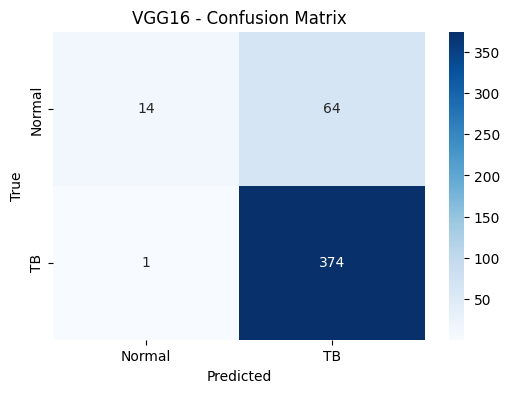

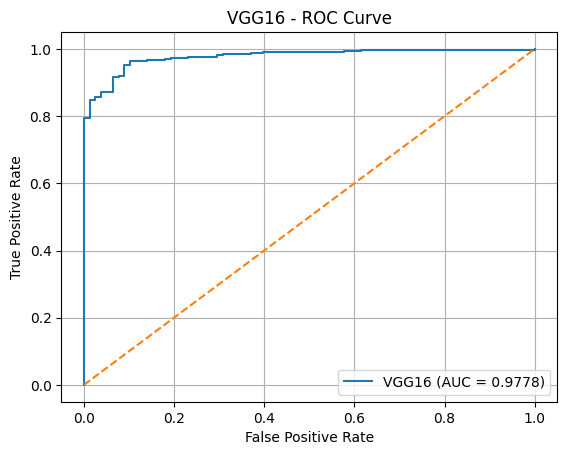

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 48s 555ms/step - accuracy: 0.7995 - loss: 0.5870 - val_accuracy: 0.8293 - val_loss: 0.4553
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 424ms/step - accuracy: 0.7939 - loss: 0.5470 - val_accuracy: 0.8293 - val_loss: 0.4568
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 422ms/step - accuracy: 0.8184 - loss: 0.5051 - val_accuracy: 0.8293 - val_loss: 0.4598
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 423ms/step - accuracy: 0.7986 - loss: 0.5406 - val_accuracy: 0.8293 - val_loss: 0.4580
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 430ms/step - accuracy: 0.7917 - loss: 0.5566 - val_accuracy: 0.8293 - val_loss: 0.4559
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 427ms/step - accuracy: 0.8270 - loss: 0.4676 - val_accuracy: 0.8293 - val_loss: 0.4736
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 433ms/step - accuracy: 0.8278 - loss: 0.4802 - val_accuracy: 0.8293 - val_loss: 0.4884
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 427ms/step - accuracy: 0.8088 - loss: 0.5076 - val_accu

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step
📊 ResNet50 Classification Report:

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        78
Tuberculosis       0.83      1.00      0.91       375

    accuracy                           0.83       453
   macro avg       0.41      0.50      0.45       453
weighted avg       0.69      0.83      0.75       453



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


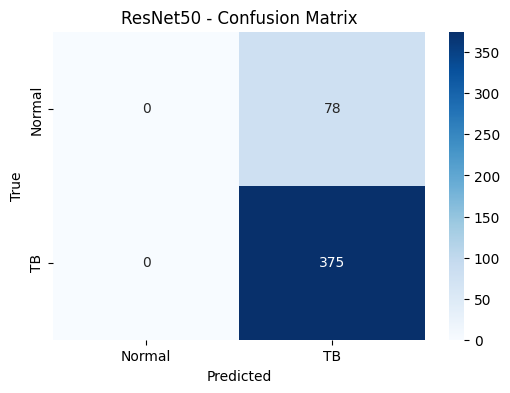

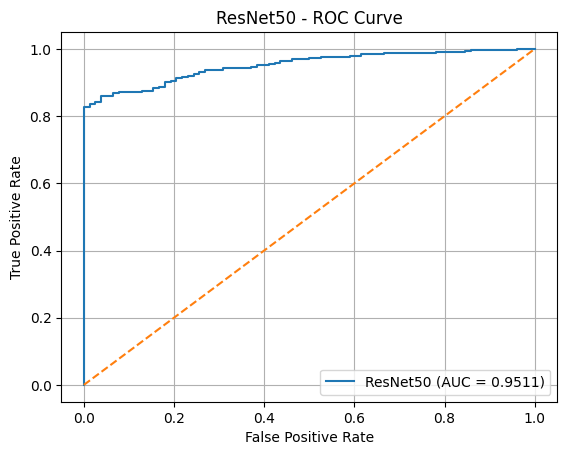

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 674ms/step - accuracy: 0.7955 - loss: 0.5095 - val_accuracy: 0.8293 - val_loss: 0.4581
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 461ms/step - accuracy: 0.8296 - loss: 0.4727 - val_accuracy: 0.8293 - val_loss: 0.4588
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 421ms/step - accuracy: 0.8285 - loss: 0.4653 - val_accuracy: 0.8293 - val_loss: 0.4571
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 401ms/step - accuracy: 0.8470 - loss: 0.4396 - val_accuracy: 0.8293 - val_loss: 0.4588
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 400ms/step - accuracy: 0.8385 - loss: 0.4606 - val_accuracy: 0.8293 - val_loss: 0.4578
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 399ms/step - accuracy: 0.8375 - loss: 0.4610 - val_accuracy: 0.8293 - val_loss: 0.4588
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 416ms/step - accuracy: 0.8308 - loss: 0.4612 - val_accuracy: 0.8293 - val_loss: 0.4573
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 32s 482ms/step - accuracy: 0.8210 - loss: 0.4772 - val_accu

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 547ms/step
📊 EfficientNetB0 Classification Report:

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        78
Tuberculosis       0.83      1.00      0.91       375

    accuracy                           0.83       453
   macro avg       0.41      0.50      0.45       453
weighted avg       0.69      0.83      0.75       453



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


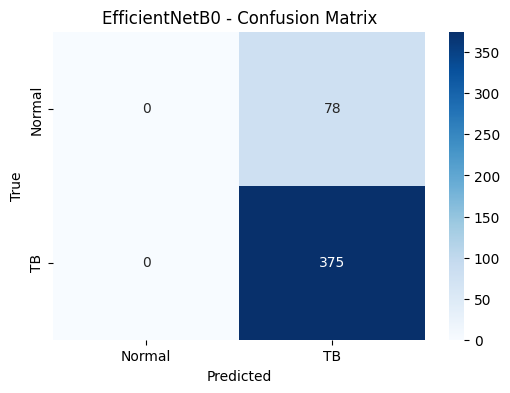

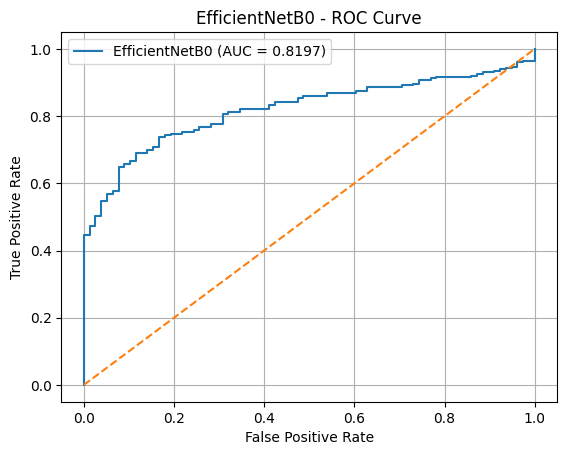

<ipython-input-12-d8bbb3116922>:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=auc_scores, palette='viridis')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


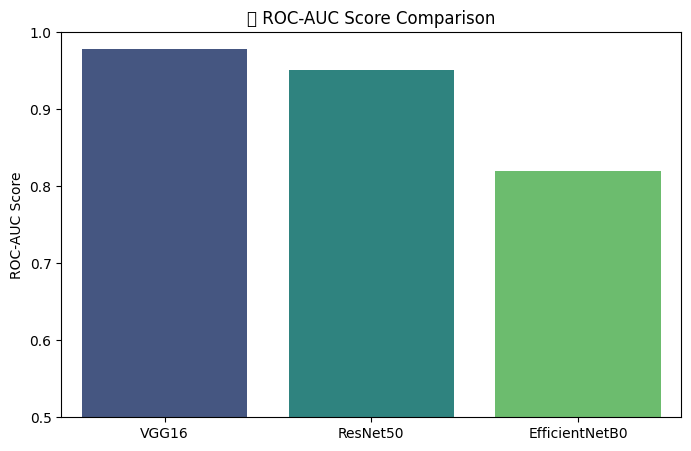

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load and preprocess data
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.2, rotation_range=20, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/content/chest_xray_split/train', target_size=(224, 224), batch_size=32, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory('/content/chest_xray_split/val', target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory('/content/chest_xray_split/test', target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# 2. Model builder function
def build_model(base_model, dropout_rate=0.5):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=predictions)

# 3. Training function
def train_model(model, name):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_generator, validation_data=val_generator, epochs=10)
    model.save(f'{name}_model.h5')
    return model, history

# 4. Evaluation function
def evaluate_model(model, name):
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    print(f"📊 {name} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Tuberculosis']))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'TB'], yticklabels=['Normal', 'TB'])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC-AUC
    auc_score = roc_auc_score(y_true, y_pred_probs)
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    return auc_score

# 5. Train and Evaluate all Models

# VGG16
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_base.layers: layer.trainable = False
vgg_model, _ = train_model(build_model(vgg_base), 'vgg')
vgg_auc = evaluate_model(vgg_model, 'VGG16')

# ResNet50
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in resnet_base.layers: layer.trainable = False
resnet_model, _ = train_model(build_model(resnet_base), 'resnet')
resnet_auc = evaluate_model(resnet_model, 'ResNet50')

# EfficientNetB0
eff_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in eff_base.layers: layer.trainable = False
eff_model, _ = train_model(build_model(eff_base), 'effnet')
eff_auc = evaluate_model(eff_model, 'EfficientNetB0')

# 6. Compare AUC Scores
models = ['VGG16', 'ResNet50', 'EfficientNetB0']
auc_scores = [vgg_auc, resnet_auc, eff_auc]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=auc_scores, palette='viridis')
plt.title("📈 ROC-AUC Score Comparison")
plt.ylabel("ROC-AUC Score")
plt.ylim(0.5, 1.0)
plt.show()
